In [4]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.insert(0, '../')
from common.utils import *
import numpy as np
import scipy as sp
import cv2
from tqdm import tqdm
from glob2 import glob

Using TensorFlow backend.


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/cvlab/anaconda2/envs/roadar/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['squeeze']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
resolutions = [(64*i,192*i) for i in range(1,5)][::-1]

n_rows,n_cols = resolutions[0]
im_shape = (n_rows,n_cols)
n_channels = 3
input_shape = (n_rows,n_cols,n_channels)

In [7]:
DATA_ROOT = '/storage/cvlab/RDC/winter_track/'
TRAIN_DIR = DATA_ROOT+'/SegDataSet_Cityscape_Kitti_Kia_Wilddash/'
im_paths = np.array(glob(TRAIN_DIR + 'resized_image/'  +  '*.*'))
masks_paths = np.array(glob(TRAIN_DIR + 'resized_label/' +  '*.*'))
kia_idx = in_filename(im_paths)
kia_match = np.ones(len(im_paths), dtype=bool)
kia_match[kia_idx] = False
kia_im_paths = im_paths[kia_idx]
kia_mask_paths = masks_paths[kia_idx]
im_paths = im_paths[kia_match]
masks_paths = masks_paths[kia_match]

In [8]:
X_segdat = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(im_paths[:100])])
y_segdat = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(masks_paths[:100])])
y_segdat = binarize_mask(y_segdat)

100%|██████████| 100/100 [00:00<00:00, 152.58it/s]


In [9]:
X_kia = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(kia_im_paths)])
y_kia = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(kia_mask_paths)])
y_kia = binarize_mask(y_kia)

100%|██████████| 9/9 [00:00<00:00, 159.52it/s]


In [10]:
IMAGE_H = 256
IMAGE_W = 768
k = 7
img = cv2.cvtColor(X_kia[k],cv2.COLOR_BGR2GRAY)
mask = y_kia[k]
src = np.float32([ [IMAGE_W, 0], [0, IMAGE_H], [0, 0], [IMAGE_W, IMAGE_H]])
dst = np.float32([ [IMAGE_W, 0], [380, IMAGE_H], [0, 0], [IMAGE_W-300, IMAGE_H]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
img_crop = img[110:(110+IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
mask_crop = mask[110:(110+IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
warped_img = cv2.warpPerspective(img_crop.copy(), M, (IMAGE_W, IMAGE_H),flags=cv2.INTER_LINEAR) 
warped_mask = cv2.warpPerspective(mask_crop.copy(), M, (IMAGE_W, IMAGE_H),flags=cv2.INTER_LINEAR)
th = 50
edt = sp.ndimage.morphology.distance_transform_bf(warped_mask)
edt[edt>th] = th
edt = np.invert(edt.astype('uint8'))

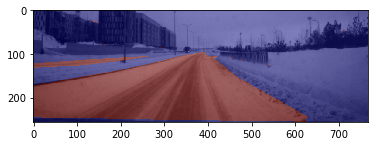

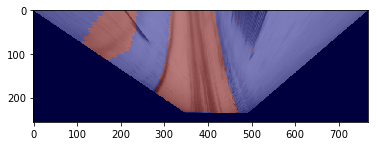

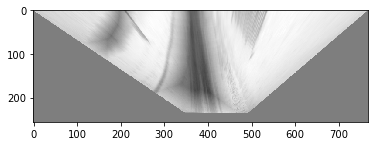

In [11]:
imshow(img,cmap='gray')
imshow(mask,cmap='jet',alpha=0.5)
show()
show()
imshow(warped_img,cmap='gray')
imshow(warped_mask,alpha=0.5,cmap='jet')
show()
imshow(warped_img,cmap='gray')
imshow(edt,alpha=0.5,cmap='gray')